# **Dice number classification algorithm**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

import generateDataset as db

/home/morooka/.local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


# Read database

Functions used to read the database (train and test) from MNIST and also from the csv file generated with the images captured from the pico camera

In [2]:
def separate_array(data):    
    image = []
    labels = []
    for line in data:
        image.append(np.array(line[:-1]))
        labels.append(line[-1])
    
    return image, labels

In [3]:
X_train, Y_train = separate_array(np.load('./photosFeatures_train.npy'))

In [4]:
X_validation, Y_validation = separate_array(np.load('./photosFeatures_validation.npy'))

In [5]:
print len(Y_validation)
print len(Y_train)

1350
5130


# **Evaluation methods**

This part contains the functions used to analyse the accuracy of the classifier

In [6]:
def plot_confusion_matrix(clf, data_x, data_y):
    classes = range(1,7)
    
    Ypred = clf.predict(data_x)
    
    # Computation of confusion matrix on testing set
    cm = confusion_matrix(data_y, Ypred)
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# **Random Forest algorithm**

In [7]:
def create_number_list(data):
    images = []
    for x in data:
        images.append(x.reshape(-1))

    return images

In [8]:
def train_randomForest_Model(i, X_data, Y_data):
    # Train on the train images
    train_x = create_number_list(X_data)
    train_y = np.array(Y_data)
    
    #Train the classifier
    clf = RandomForestClassifier(n_estimators = i)
    print("Finished trainning Random Forest Model with " + str(i) + " number of estimators")
    
    return clf.fit(train_x, train_y)

In [9]:
def visualize_randomForest_Model(clf, X_data, Y_data, filename, typeData):
    # Visualize on the dataset images:
    data_x = create_number_list(X_data)
    data_y = Y_data 
    predicted = clf.predict(data_x)
    
    plot_confusion_matrix(clf, data_x, data_y)
    plt.title(typeData + ' confusion matrix: accuracy of ' + str(round((accuracy_score(data_y, predicted) * 100), 3)) + "% \n Used " + str(len(data_x)) + " images")
    plt.savefig(filename)

In [16]:
randomForest_classifier = train_randomForest_Model(10, X_train, Y_train)

Finished trainning Random Forest Model with 10 number of estimators


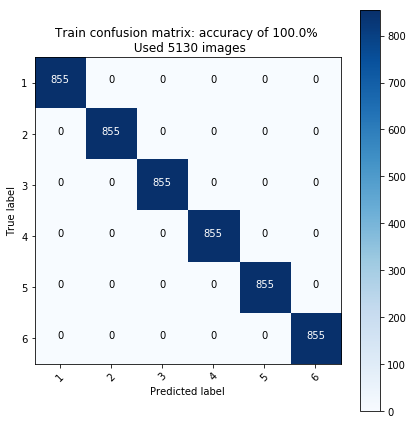

In [17]:
visualize_randomForest_Model(randomForest_classifier, X_train, Y_train,'./Results/randomForest/train', 'Train')

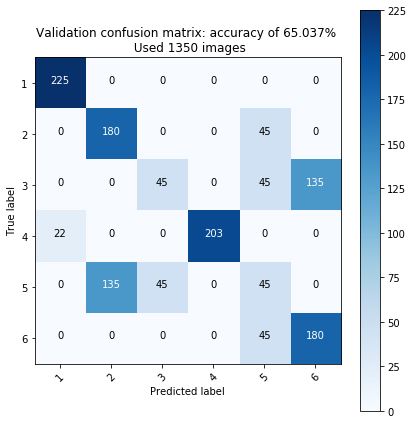

In [18]:
visualize_randomForest_Model(randomForest_classifier, X_validation, Y_validation,'./Results/randomForest/validation', 'Validation')

In [19]:
# save the classifier
filename = './Results/randomForest/randomForest_classifier.sav'
joblib.dump(randomForest_classifier, filename, compress = 3)  

['./Results/randomForest/randomForest_classifier.sav']

# **Multiple Hyperparameter Study**
This part consist in making a study of the hyperparameter of the classifier, using the gridsearch method from the scikitlearn library.

In [13]:
# Define the parameter values that should be searched
estimators_range = list(range(1, 25))

# Another parameter besides max_depth that we might vary is the criteria
criterion_options = ['gini', 'entropy']
#features_options = ['auto', 'sqrt','log2', None]

# Specify "parameter grid"
grid_parameters = dict(n_estimators=estimators_range, criterion=criterion_options)

# Specify "parameter distributions" rather than a "parameter grid"
dist_parameters = dict(n_estimators=estimators_range, criterion=criterion_options)

# Since both parameters are discrete, so param_dist is the same as param_grid

# Finally define the classifier, in this case the DecisionTree classifier
new_randomForest = RandomForestClassifier()

In [14]:
# This block is done both grid and random search for the hyperparameters for N numbers
def compute_best_classifier(X_data, Y_data, param_grid, param_dist, model):
    grid_best_scores = []
    grid_best_params = []
    grid_best_estimator = []

    rand_best_scores = []
    rand_best_params = []
    rand_best_estimator = []

    train_x = create_number_list(X_data)
    train_y = np.array(Y_data)

    for i in list(range(15)):
        print("Iteration num: " + str(i))
        grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', n_jobs = -1)
        grid.fit(train_x, train_y)
        grid_best_scores.append(grid.best_score_)
        grid_best_params.append(grid.best_params_)
        grid_best_estimator.append(grid.best_estimator_)

        rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, n_jobs = -1)
        rand.fit(train_x, train_y)
        rand_best_scores.append(rand.best_score_)
        rand_best_params.append(rand.best_params_)
        rand_best_estimator.append(rand.best_estimator_)

    print("Finished searching the hyper parameters!")
    
    # This block draw accuracies of the differents classifiers used in the grid and random search

    plt.figure(figsize=(16, 8))
    plt.title("Final search results")   
    plt.plot(range(len(grid_best_scores)), grid_best_scores, label = 'Exaustive grid')
    plt.plot(range(len(rand_best_scores)), rand_best_scores, label = 'Random grid')
    plt.xlabel('Number of classifier')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(len(grid_best_scores)))
    plt.savefig('./Results/randomForest/tuningParameters')
    #plt.show()

    print("GRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(grid_best_scores) * 100) + "%")
    print("The parameters is: " + str(grid_best_params[np.argmax(grid_best_scores)]))
    print('\n')
    print("RANDOMGRID SEARCH RESULTS")
    print("The best accuracy is: " + str(np.max(rand_best_scores) * 100) + "%")
    print("The parameters is: " + str(rand_best_params[np.argmax(rand_best_scores)]))

    return rand_best_estimator[np.argmax(rand_best_scores)]

# BEST RandomForest Classifier + Photos Test

In [15]:
#Train the best classificator for a N sample of numbers
def train_best_classifier(X_data, Y_data, grid_par, dist_par, model):   
    classificator = compute_best_classifier(X_data, Y_data, grid_par, dist_par, model)

    return classificator.fit(X_data, Y_data)

Iteration num: 0
Iteration num: 1
Iteration num: 2
Iteration num: 3
Iteration num: 4
Iteration num: 5
Iteration num: 6
Iteration num: 7
Iteration num: 8
Iteration num: 9
Iteration num: 10
Iteration num: 11
Iteration num: 12
Iteration num: 13
Iteration num: 14
Finished searching the hyper parameters!
GRID SEARCH RESULTS
The best accuracy is: 74.89070362121588%
The parameters is: {'n_estimators': 23, 'criterion': 'entropy'}


RANDOMGRID SEARCH RESULTS
The best accuracy is: 74.76697187164893%
The parameters is: {'n_estimators': 22, 'criterion': 'entropy'}
CPU times: user 3h 32min 38s, sys: 6min, total: 3h 38min 39s
Wall time: 5h 28min 39s


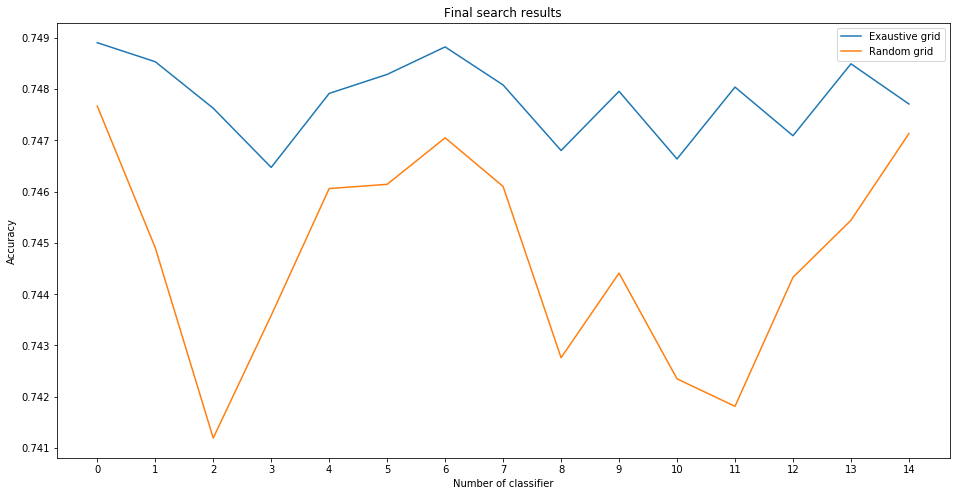

In [16]:
%%time

best_randomForest_classifier = train_best_classifier(X_train, Y_train, grid_parameters, dist_parameters, new_randomForest)


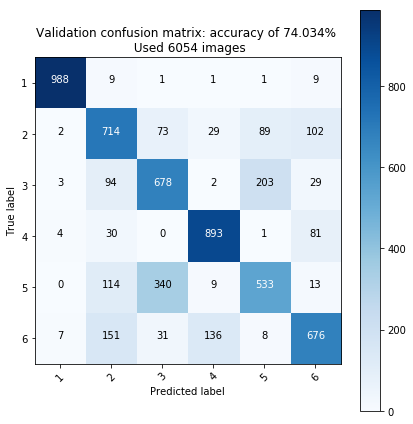

In [17]:
visualize_randomForest_Model(best_randomForest_classifier, X_validation, Y_validation,'./Results/randomForest/best_validation', 'Validation')

1620


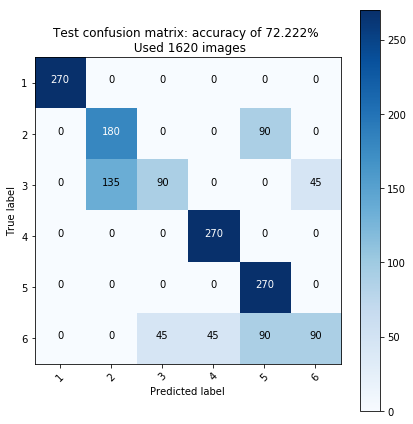

In [23]:
X_test, Y_test = separate_array(np.load('./photosFeatures_test.npy'))
visualize_randomForest_Model(randomForest_classifier, X_test, Y_test,'./Results/randomForest/test', 'Test')
print(len(X_test))

In [20]:
# save the classifier
filename = './Results/randomForest/best_randomForest_classifier.sav'
joblib.dump(best_randomForest_classifier, filename, compress = 3)  

['./Results/randomForest/best_randomForest_classifier.sav']

# Features study for Random Forest classifier

In a Random Forest model the feature used to make the classification is very important, so in this part it is made a study on the best feature

In [22]:
%%time

training_set = db.create_train_data_list()


Loading Training dataset and Testing dataset from MNIST...
Finished loading the datasets!

------------------[TEST DATASET]-----------------------
Number of numbers in the testset: 7572

Classes are BALANCED!, with 1262 sample for class

./test.npyfile does not exist, creating one!
Created test database
--------------------------------------------------------

------------------[TRAIN DATASET]-----------------------
Number of numbers in the trainset: 24246

Classes are BALANCED!, with 4039 sample for class

Removing ./train.npy
Created train database
--------------------------------------------------------

------------------[VALIDATION DATASET]------------------
Number of numbers in the validationset: 6054

Classes are BALANCED!, with 1009 sample for class

./validation.npyfile does not exist, creating one!
Created validation database
--------------------------------------------------------

Removing ./test.npy
Removing ./validation.npy
Generating TRAIN data...
Creating dataset...

F

In [23]:
#This part displays the table of importance of each feature

bins = np.arange(len(training_set.digits[0].features))
label_list = []
for feature in training_set.digits[0].features:
    label_list.append(feature)

importance = randomForest_classifier.feature_importances_
df = pd.DataFrame({'feature': label_list, 'Level of importance': importance})
df.sort_values(by = ['Level of importance']).reset_index()

,index,Level of importance,feature
0,4,0.034135,active_PC_X
1,8,0.051586,std_PC_Y
2,1,0.057209,mean_grad_D
3,11,0.059253,mean_PC_X
4,7,0.069362,std_PC_X
5,5,0.075212,active_PC_Y
6,0,0.086709,std_grad_M
7,10,0.088252,mean_PC_Y
8,2,0.094101,std_grad_D
9,6,0.096545,std


[Text(0,0,'std_grad_M'),
 Text(0,0,'mean_grad_D'),
 Text(0,0,'std_grad_D'),
 Text(0,0,'var'),
 Text(0,0,'active_PC_X'),
 Text(0,0,'active_PC_Y'),
 Text(0,0,'std'),
 Text(0,0,'std_PC_X'),
 Text(0,0,'std_PC_Y'),
 Text(0,0,'mean_grad_M'),
 Text(0,0,'mean_PC_Y'),
 Text(0,0,'mean_PC_X')]

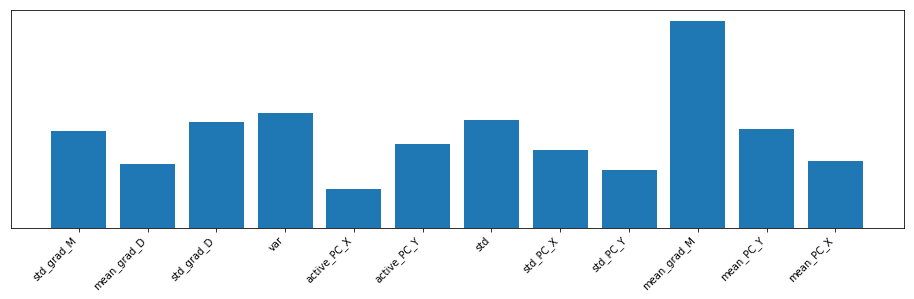

In [24]:
# This part plots a grafic for better visualization

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.bar(bins, importance)
ax.set_xticks(np.arange(len(label_list)))
ax.set_yticks([])
ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
# Display bar graph of feature importances with feature names as labels